In [15]:
!pip install japanize_matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from scipy import signal
from scipy.signal import find_peaks

## センサデータの取得

In [17]:
acc_file_path = "./data/PDR-introduction 2025-05-26 11-26-40/Accelerometer.csv"
gyro_file_path = "./data/PDR-introduction 2025-05-26 11-26-40/Gyroscope.csv"

# 通信してデータを取得
df_acc = pd.read_csv(acc_file_path)
df_gyro = pd.read_csv(gyro_file_path)

# センサデータの加工

## ウィンドウの宣言

In [18]:
window_acc = 100
window_pre = 240
window_gyro = 700
shift_amount = window_pre * -1

## 生データの描画

<Figure size 640x480 with 0 Axes>

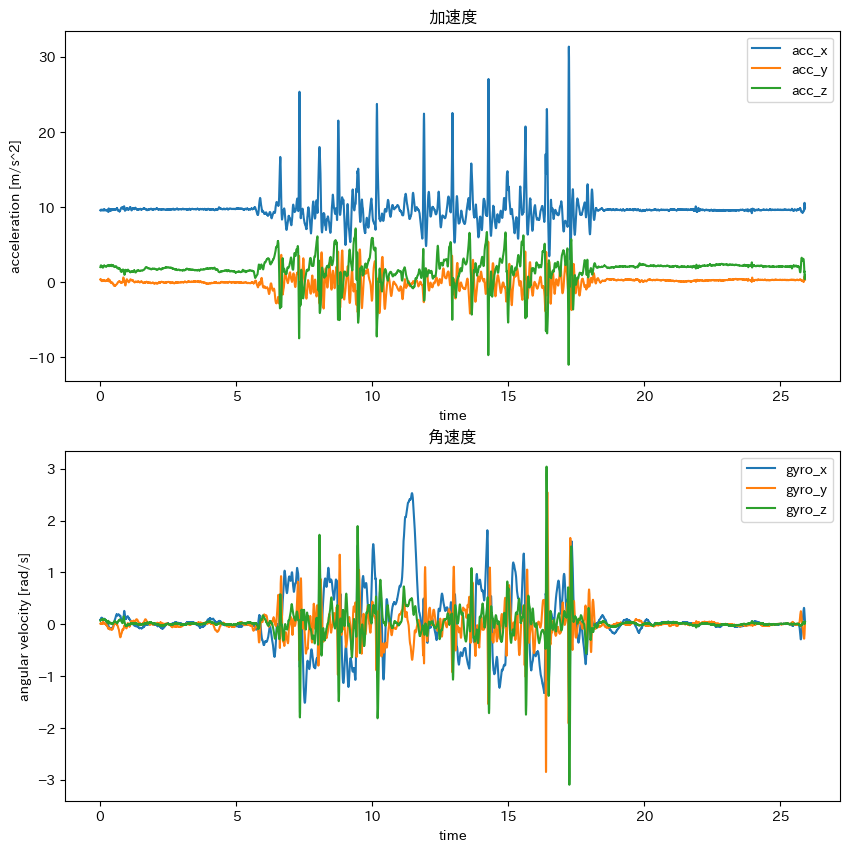

In [19]:
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 10))

# 加速度のプロット
ax1 = fig.add_subplot(2,1,1)
ax1.title.set_text("加速度")
ax1.plot(df_acc["t"], df_acc["x"], label="acc_x")
ax1.plot(df_acc["t"], df_acc["y"], label="acc_y")
ax1.plot(df_acc["t"], df_acc["z"], label="acc_z")
ax1.set_xlabel("time")
ax1.set_ylabel("acceleration [m/s^2]")
##ax1.set_xlim(0, 100)
##ax1.set_ylim(-10, 50)
ax1.legend()

# ジャイロのプロット
ax2 = fig.add_subplot(2,1,2)
ax2.title.set_text("角速度")
ax2.plot(df_gyro["t"], df_gyro["x"], label="gyro_x")
ax2.plot(df_gyro["t"], df_gyro["y"], label="gyro_y")
ax2.plot(df_gyro["t"], df_gyro["z"], label="gyro_z")
ax2.set_xlabel("time")
ax2.set_ylabel("angular velocity [rad/s]")
##ax2.set_xlim(0, 100)
# ax2.set_ylim(-10, 50)
ax2.legend()

plt.show()

## 余分な時間のデータを消す

In [20]:
# # 5s ~ 90sのデータを抽出
df_acc = df_acc[(df_acc['t'] >= 5) & (df_acc['t'] <= 20)]
df_gyro = df_gyro[(df_gyro['t'] >= 5) & (df_gyro['t'] <= 20)]

# # index をリセット
df_acc = df_acc.reset_index(drop=True)
df_gyro = df_gyro.reset_index(drop=True)

## 整形したデータの描画

<Figure size 640x480 with 0 Axes>

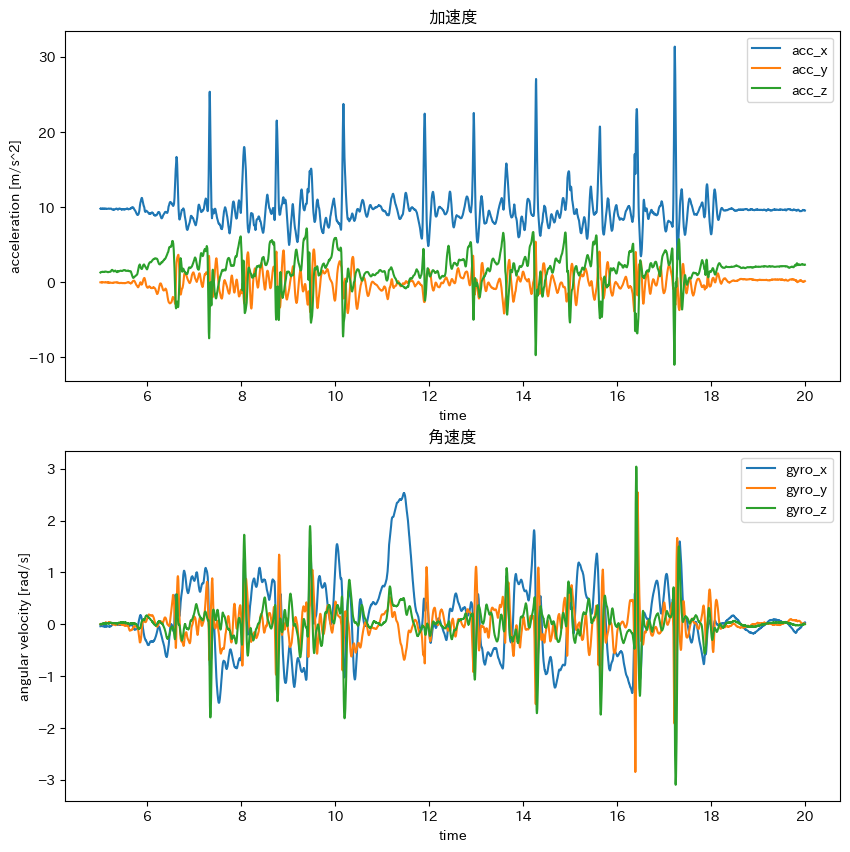

In [21]:
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 10))

# 加速度のプロット
ax1 = fig.add_subplot(2,1,1)
ax1.title.set_text('加速度')
ax1.plot(df_acc["t"], df_acc["x"], label="acc_x")
ax1.plot(df_acc["t"], df_acc["y"], label="acc_y")
ax1.plot(df_acc["t"], df_acc["z"], label="acc_z")
ax1.set_xlabel("time")
ax1.set_ylabel("acceleration [m/s^2]")
# ax1.set_xlim(20, 90)
# ax1.set_ylim(-10, 20)
ax1.legend()

# ジャイロのプロット
ax2 = fig.add_subplot(2,1,2)
ax2.title.set_text('角速度')
ax2.plot(df_gyro["t"], df_gyro["x"], label="gyro_x")
ax2.plot(df_gyro["t"], df_gyro["y"], label="gyro_y")
ax2.plot(df_gyro["t"], df_gyro["z"], label="gyro_z")
ax2.set_xlabel("time")
ax2.set_ylabel("angular velocity [rad/s]")
# ax1.set_xlim(20, 90)
# ax2.set_ylim(-10, 20)
ax2.legend()

plt.show()

## ノルムの算出,移動平均フィルター

In [22]:
df_acc['norm'] = (df_acc['x']**2 + df_acc['y']**2 + df_acc['z']**2)**(1/2)
df_gyro['norm'] = (df_gyro['x']**2 + df_gyro['y']**2 + df_gyro['z']**2)**(1/2)

df_gyro['angle'] = np.cumsum(df_gyro['x']) / 100

df_acc['low_norm'] = df_acc['norm'].rolling(window= window_acc).mean()
df_acc['shift_low_norm'] = df_acc['low_norm'].shift(shift_amount * -1)
df_gyro['low_x'] = df_gyro['x'].rolling(window= window_gyro).mean()
df_gyro['low_angle'] = df_gyro['angle'].rolling(window= window_gyro,center=True).mean()

<Figure size 640x480 with 0 Axes>

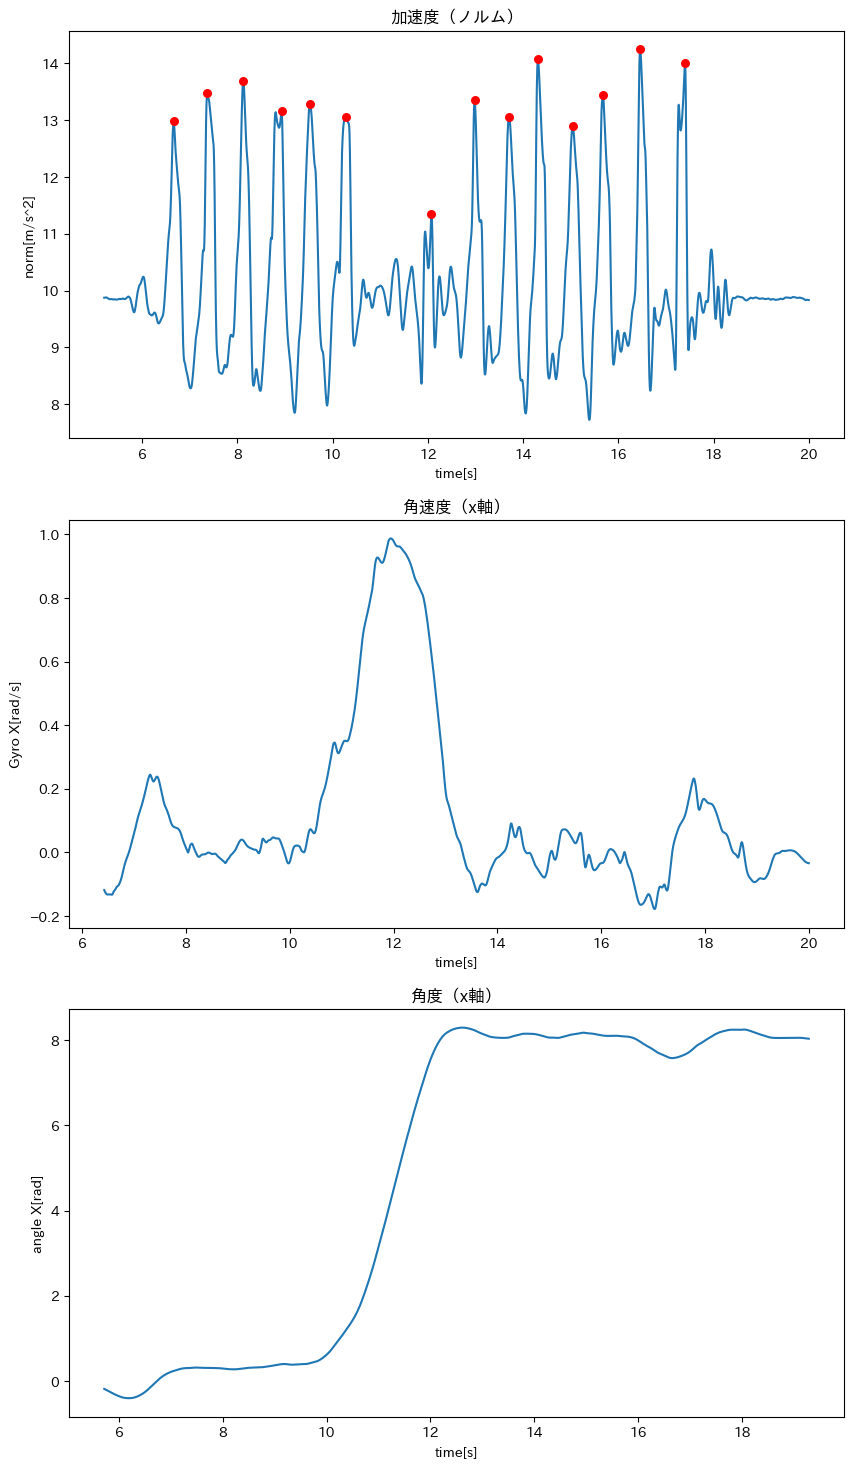

In [23]:
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 18))

# 加速度（ノルム）のプロット
ax1 = fig.add_subplot(3,1,1)
ax1.plot(df_acc["t"], df_acc["low_norm"])
ax1.set_title("加速度（ノルム）")
ax1.set_xlabel("time[s]")
ax1.set_ylabel("norm[m/s^2]")

# ピークの検出とプロット
peek, _ = signal.find_peaks(df_acc['low_norm'], distance=100, height=11)
ax1.scatter(df_acc['t'][peek], df_acc['low_norm'][peek], s=30, color='red', zorder=2)

# 角速度（x軸）のプロット
ax2 = fig.add_subplot(3,1,2)
ax2.plot(df_gyro["t"], df_gyro["low_x"])
ax2.set_title("角速度（x軸）")
ax2.set_xlabel("time[s]")
ax2.set_ylabel("Gyro X[rad/s]")

# 角度（x軸）のプロット
ax3 = fig.add_subplot(3,1,3)
ax3.plot(df_gyro["t"], df_gyro["low_angle"])
ax3.set_title("角度（x軸）")
ax3.set_xlabel("time[s]")
ax3.set_ylabel("angle X[rad]")

plt.show()

# 軌跡の描画

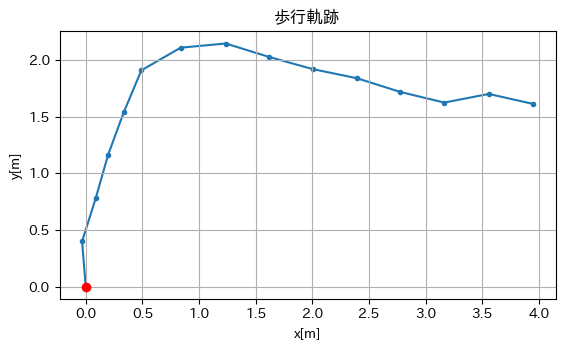

In [24]:
# 軌跡を描く
step = 0.4
point = [[0, 0]]

for p in peek:
    x = step * np.sin(df_gyro['low_angle'][p]*1) + point[-1][0]
    y = step * np.cos(df_gyro['low_angle'][p]*1) + point[-1][1]

    point.append([x, y])

point = pd.DataFrame(data=point, columns=['x', 'y'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]

# 描画
size = ((-1, 10), (-1, 10))

plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)

# 原点を赤で描画
plt.plot(0, 0, 'ro', label='原点', zorder=2)  # 'ro' は red + circle

# 軸を揃える
plt.gca().set_aspect('equal', adjustable='box')

plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
# plt.xticks(np.arange(size[0][0], size[0][1], 0.5))
# plt.yticks(np.arange(size[1][0], size[1][1], 0.5))
# plt.xlim(size[0][0], size[0][1])
# plt.ylim(size[1][0], size[1][1])

plt.grid()
plt.show()

## csvファイルの作成

In [ ]:
# 5. CSVファイルへの保存
csv_file_name = 'walking_trajectory.csv'
if not point.empty:
    try:
        point.to_csv(csv_file_name, index=False)
        print(f"'{csv_file_name}' が正常に作成されました。")
        print("DataFrameの内容 (最初の5行):")
        print(point.head())
    except Exception as e:
        print(f"CSVファイル保存中にエラーが発生しました: {e}")
else:
    print("保存する軌跡データがありません。")